In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from xgboost import plot_importance
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

Importing the dataset and making necessary transformation.

In [18]:
from pickle import DEFAULT_PROTOCOL
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = df.drop(columns=['Province/State','Lat', 'Long'])
df_confirmed_country = df[df["Country/Region"] == "US"]
df_confirmed_country=pd.melt(df_confirmed_country,id_vars=['Country/Region'],var_name='date', value_name='Count')
df_confirmed_country=df_confirmed_country.drop(columns=['Country/Region'])
df_confirmed_country = df_confirmed_country.set_index('date')
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index)
df_confirmed_country

,Count
date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2022-10-31,97503019
2022-11-01,97550350
2022-11-02,97622888


Visualising the trend of the confirmed cases throughout the years.

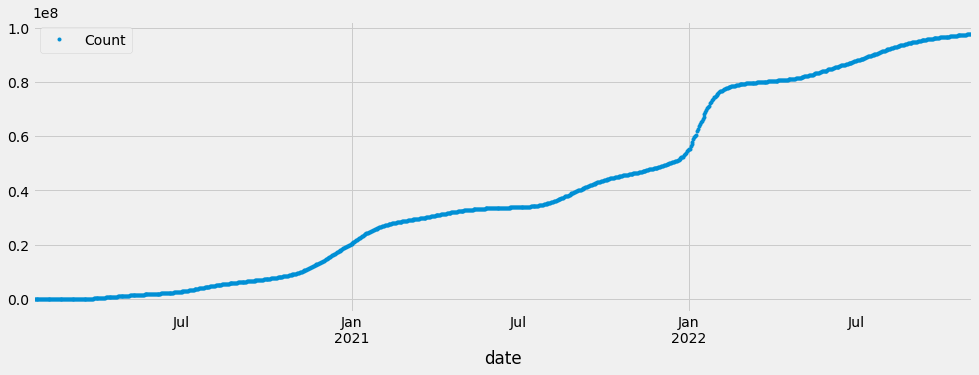

In [19]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df_confirmed_country.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='')
plt.show()

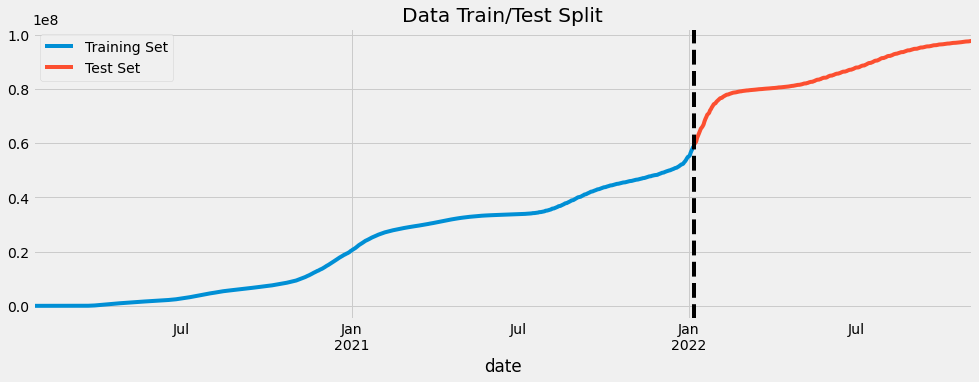

In [20]:
train = df_confirmed_country.loc[df_confirmed_country.index < '01-07-2022']
test = df_confirmed_country.loc[df_confirmed_country.index >= '01-07-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-07-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [5]:
train

,Count
date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2022-01-02,55393063
2022-01-03,56436331
2022-01-04,57264459


Extracting the new features form the existing univarient feature.

In [21]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df.columns = df.columns.str.replace(' ', '')
    return df

df = create_features(df_confirmed_country)
df

,Count,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2020-01-22,1,2,1,1,2020,22,22,4
2020-01-23,1,3,1,1,2020,23,23,4
2020-01-24,2,4,1,1,2020,24,24,4
2020-01-25,2,5,1,1,2020,25,25,4
2020-01-26,5,6,1,1,2020,26,26,4
...,...,...,...,...,...,...,...,...
2022-10-31,97503019,0,4,10,2022,304,31,44
2022-11-01,97550350,1,4,11,2022,305,1,44
2022-11-02,97622888,2,4,11,2022,306,2,44


In [7]:
df.index


DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29',
               '2022-10-30', '2022-10-31', '2022-11-01', '2022-11-02',
               '2022-11-03', '2022-11-04'],
              dtype='datetime64[ns]', name='date', length=1018, freq=None)

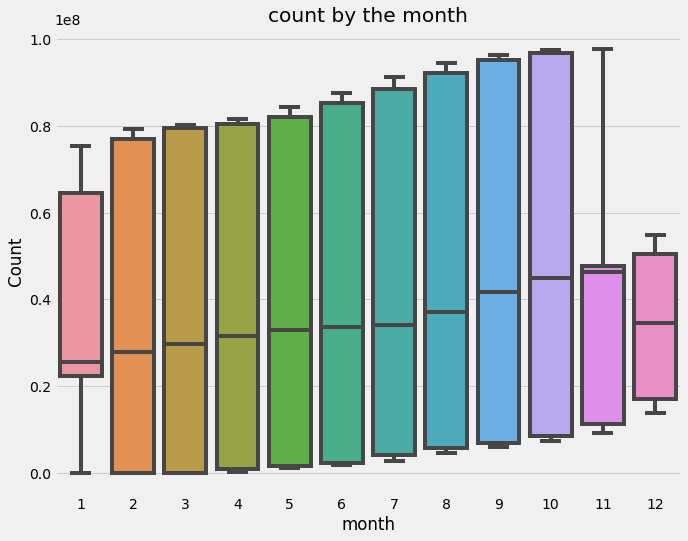

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Count')
ax.set_title('count by the month')
plt.show()

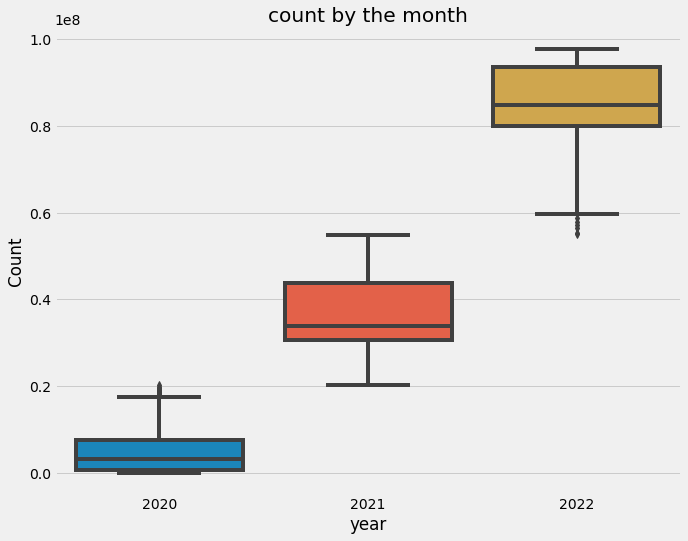

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='Count')
ax.set_title('count by the month')
plt.show()

Building the model.

In [22]:
train_new = create_features(train)
test_new = create_features(test)

FEATURES_new = [ 'quarter', 'month', 'year','dayofweek','dayofyear','dayofmonth']
TARGET_new = 'Count'

X_train_new = train[FEATURES_new]
y_train_new = train[TARGET_new]

X_test_new = test[FEATURES_new]
y_test_new = test[TARGET_new]

reg_new = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.25,
                       importance_type='weight')
reg_new.fit(X_train_new, y_train_new,
        eval_set=[(X_train_new, y_train_new), (X_test_new, y_test_new)],
        verbose=100)


[22:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.08767e+07	validation_1-rmse:7.72708e+07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

[100]	validation_0-rmse:406340	validation_1-rmse:2.35204e+07
[199]	validation_0-rmse:359975	validation_1-rmse:2.31136e+07


XGBRegressor(early_stopping_rounds=50, importance_type='weight',
             learning_rate=0.25, max_depth=2, n_estimators=200)

Making predictions on thetest set and comparing the results. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


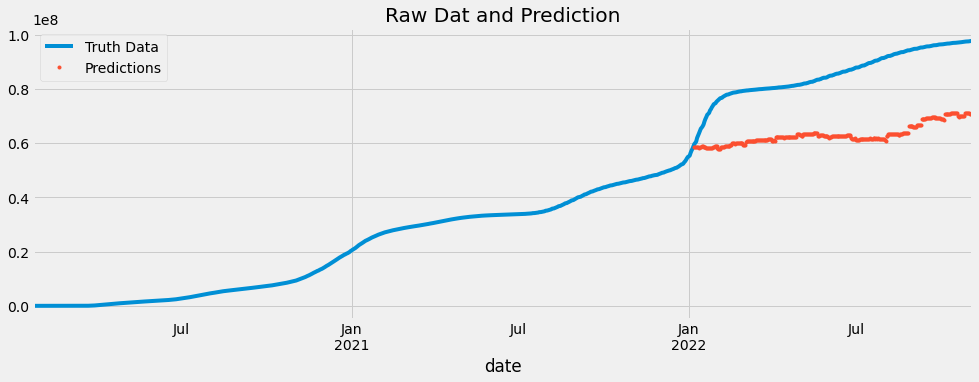

In [23]:
df_1=df
test['prediction'] = reg_new.predict(X_test_new)
df_1 = df_1.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_1[['Count']].plot(figsize=(15, 5))
df_1['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [24]:
begin_date = df.index[-1]+pd.DateOffset(1)
rng = pd.date_range(begin_date, periods=720)
next_days = pd.DataFrame({ 'Date': rng }) 
next_days=next_days.set_index('Date')
# next_days_1=create_features(next_days)
# next_days_1
next_days=create_features(next_days)
next_days_1= next_days[FEATURES_new]
type(next_days.index)

pandas.core.indexes.datetimes.DatetimeIndex

Forcasting for the next two years

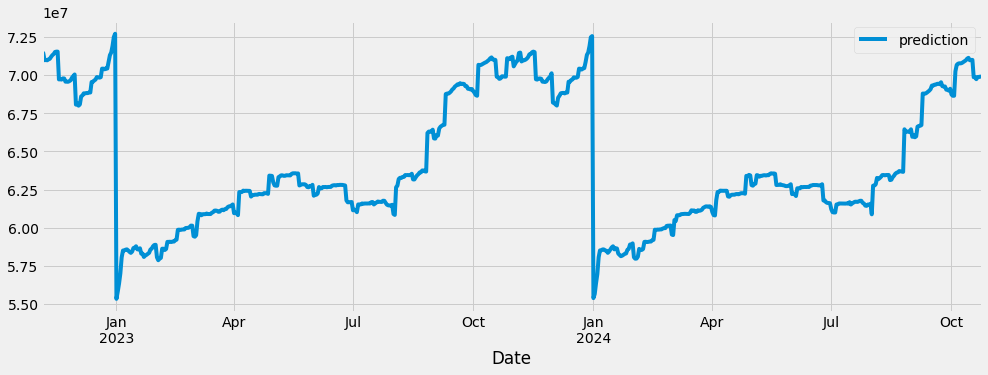

In [25]:
next_days['prediction'] = reg_new.predict(next_days_1)
ax = next_days[['prediction']].plot(figsize=(15, 5))
plt.show()


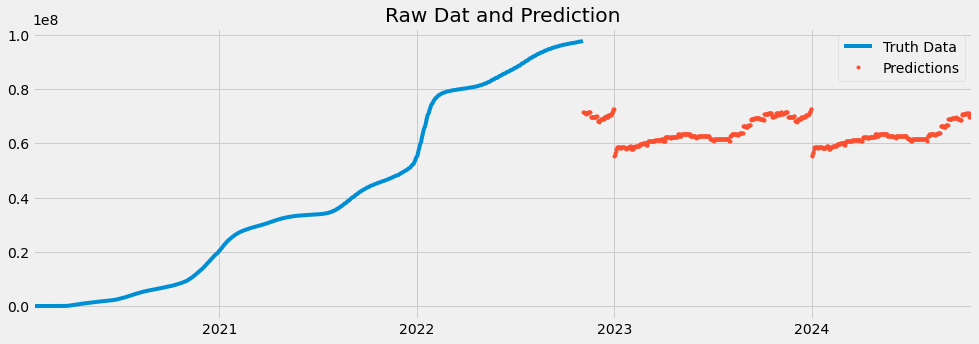

In [26]:
df_2=df
next_days['prediction'] = reg_new.predict(next_days_1)
df_2 = df_2.append(next_days)
ax = df_2[['Count']].plot(figsize=(15, 5))
df_2['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


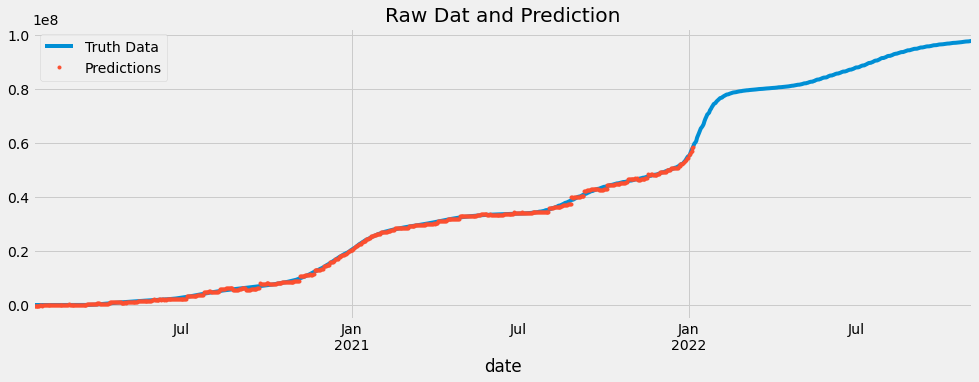

In [27]:
df_3=df
train['prediction'] = reg_new.predict(X_train_new)
df_3 = df_3.merge(train[['prediction']], how='left', left_index=True, right_index=True)
ax = df_3[['Count']].plot(figsize=(15, 5))
df_3['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


['quarter' 'month' 'year' 'dayofweek' 'dayofyear' 'dayofmonth']


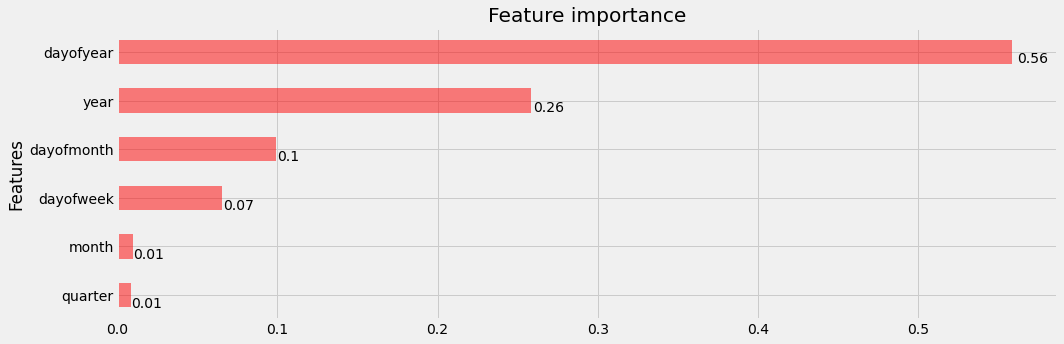

In [28]:
import pandas as pd

reg_new.feature_importances_
# In my toy example: array([0.21473685, 0.19157895, 0.28842106, 0.30526316], dtype=float32)

reg_new.feature_importances_.sum()
print(X_train_new.columns.values)
#  1.0
# Build a simple dataframe with the feature importances
# You can change the naming fN to something more human readable
fs = len(reg_new.feature_importances_)
df = pd.DataFrame(zip([X_train_new.columns.values[n] for n in range(fs)], reg_new.feature_importances_), columns=['Features', 'Feature Importance'])
df = df.set_index('Features').sort_values('Feature Importance')

# Build horizontal bar char
ax = df.plot.barh(color='red', alpha=0.5, grid=True, legend=False, title='Feature importance', figsize=(15, 5))

# Annotate bar chart, adapted from this SO answer:
# https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
for p, value in zip(ax.patches, df['Feature Importance']):
    ax.annotate(round(value, 2), (p.get_width() * 1.005, p.get_y() * 1.005))